* finetuning using pre-trained vgg16 by chainer

In [12]:
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from sklearn import manifold, metrics
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from PIL import Image
from tqdm import tqdm

In [8]:
df = pd.read_csv('./data/flower_images/flower_labels.csv')

paths = './data/flower_images/' + df['file'].as_matrix()
labels = df['label'].as_matrix()

In [10]:
dataset = []

for path, label in tqdm(zip(paths, labels)):
    
    img = Image.open(path)
    img = L.model.vision.vgg.prepare(img)
    label = np.int32(label)
    dataset.append((img, label))
    
N = len(dataset)

210it [00:00, 357.47it/s]


In [11]:
class Model(chainer.Chain):
    
    def __init__(self, out_size):
        
        super(Model, self).__init__(
            vgg = L.VGG16Layers(),
            fc = L.Linear(None, out_size)
        )
        
    def __call__(self, x, extract_feature=False):
        
        h = self.vgg(x, layers=['fc7'])['fc7']
        
        if extract_feature:
            return h
        
        y = self.fc(h)
        return y

In [15]:
gpu = 0

model = L.Classifier(Model(out_size=len(df['label'].unique())))
alpha = 1e-4
optimizer = chainer.optimizers.Adam(alpha=alpha)
optimizer.setup(model)

model.predictor['fc'].W.update_rule.hyperparam.lr = alpha*10
model.predictor['fc'].b.update_rule.hyperparam.lr = alpha*10

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)

In [19]:
epoch_num = 20
valid_size = 50
batch_size = 32

train, valid = chainer.datasets.split_dataset_random(dataset, N-valid_size)
train_iter = chainer.iterators.SerialIterator(train, batch_size)
valid_iter = chainer.iterators.SerialIterator(valid, batch_size, repeat=False, shuffle=False)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], 'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], 'epoch', file_name='accuracy.png'))
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           2.68118     2.23459               0.2            0.260417                  15.5053       
2           1.89905     2.06326               0.36875        0.208333                  17.2934       
3           1.59054     1.41786               0.3875         0.465278                  19.1006       
4           0.993789    0.923216              0.6625         0.645833                  20.9546       
5           0.530259    0.567596              0.7875         0.850694                  22.7577       
6           0.333374    1.12816               0.8875         0.697917                  24.5705       
7           0.248468    0.761587              0.94375        0.822917                  26.3619       
8           0.283027    1.09506               0.8875         0.763889                  28.1596       
9           0.28414     0.91016               0.925          0.763889               

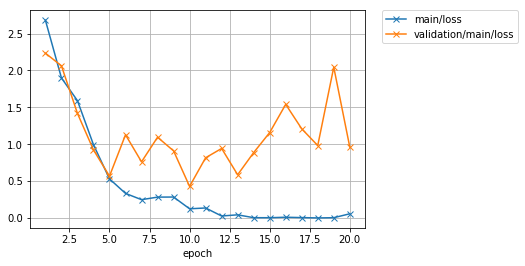

In [20]:
Image.open('result/loss.png')

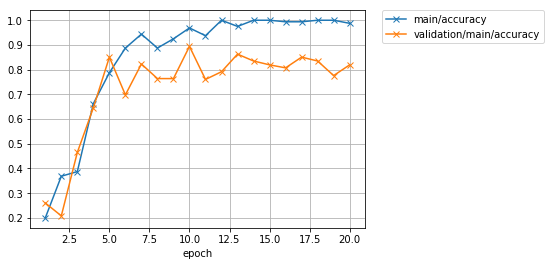

In [21]:
Image.open('result/accuracy.png')

In [30]:
preds, ys, features = [], [], []

for path, label in tqdm(zip(paths, labels)):
    
    img = Image.open(path)
    x = L.model.vision.vgg.prepare(img)
    x = x[np.newaxis]
    x = chainer.cuda.to_gpu(x)
    pred = F.argmax(F.softmax(model.predictor(x), axis=1), axis=1).data.squeeze()
    pred = chainer.cuda.to_cpu(pred)
    feature = model.predictor(x, extract_feature=True).data.reshape(-1)
    feature = chainer.cuda.to_cpu(feature)
    
    preds.append(pred)
    ys.append(label)
    features.append(feature)
    
preds = np.array(preds, dtype=np.int32)
ys = np.array(ys, dtype=np.int32)
features = np.array(features, dtype=np.float32)

210it [00:03, 53.31it/s]


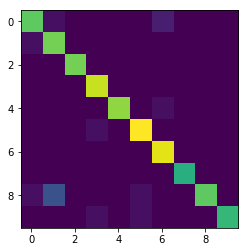

In [31]:
plt.imshow(metrics.confusion_matrix(ys, preds), interpolation='nearest')
plt.show()

In [33]:
def cos_sim_matrix(matrix):
    
    d = matrix @ matrix.T
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T

In [34]:
tsne_model = manifold.TSNE(n_components=2).fit_transform(features)
cos_sims = cos_sim_matrix(features)

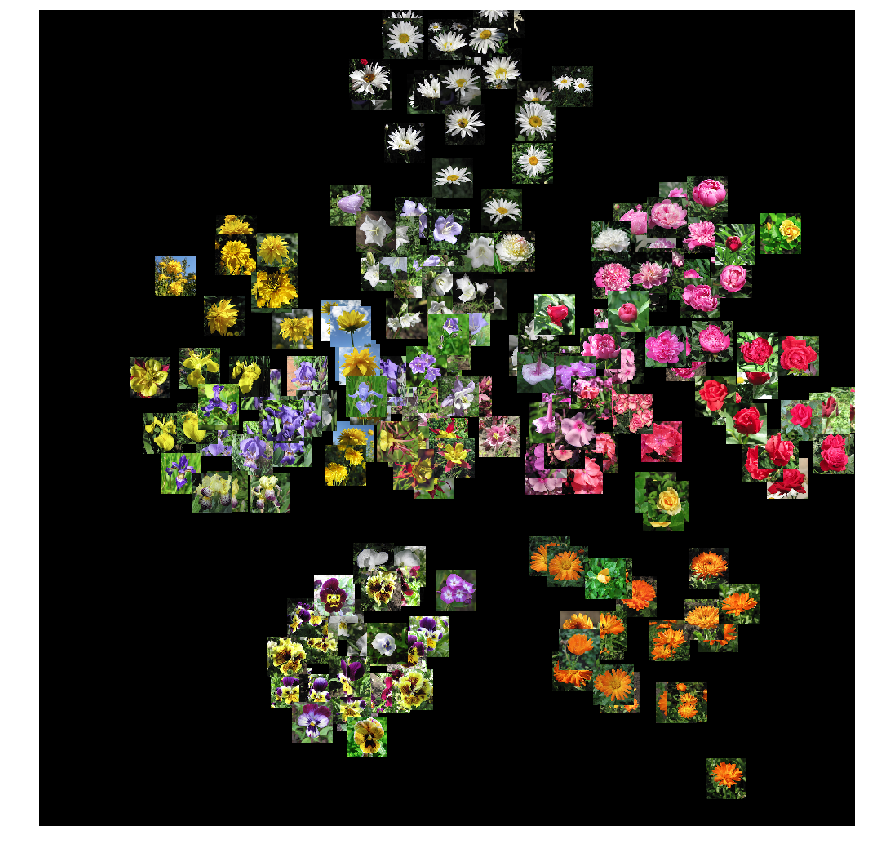

In [37]:
canvas_size = (1000, 1000)
img_size = (50, 50)
canvas = Image.new('RGB', canvas_size)

val_max = tsne_model.max()
val_min = tsne_model.min()
wide_param = 1.0

for i, path in enumerate(paths):
    
    pos_x = int(tsne_model[i][0]*(canvas_size[0]/img_size[0])/(val_max-val_min)*img_size[0]*wide_param+canvas_size[0]/2)
    pos_y = int(tsne_model[i][1]*(canvas_size[1]/img_size[1])/(val_max-val_min)*img_size[1]*wide_param+canvas_size[1]/2)
    
    target_img = Image.open(path)
    target_img = target_img.resize(img_size)
    canvas.paste(target_img, (pos_x, pos_y))
    target_img.close()
    
plt.figure(figsize=(15,15))
plt.imshow(np.array(canvas))
plt.axis('off')
plt.show()

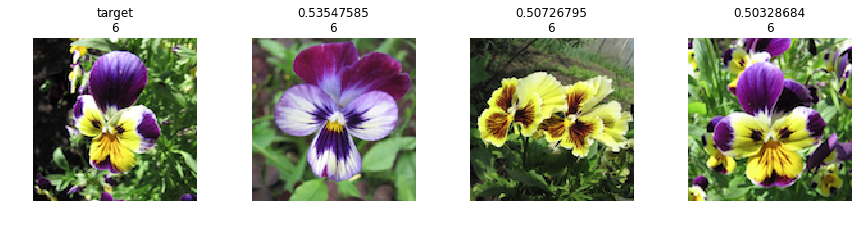

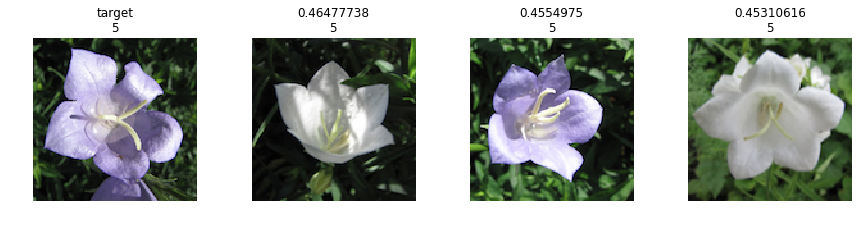

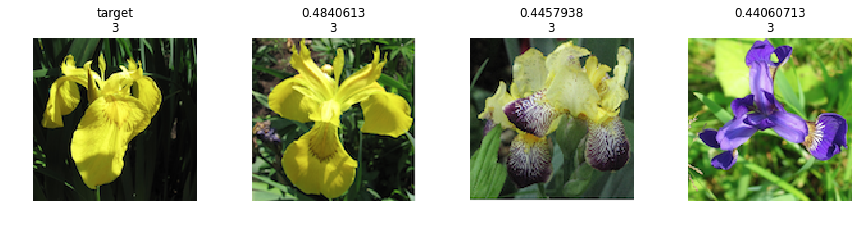

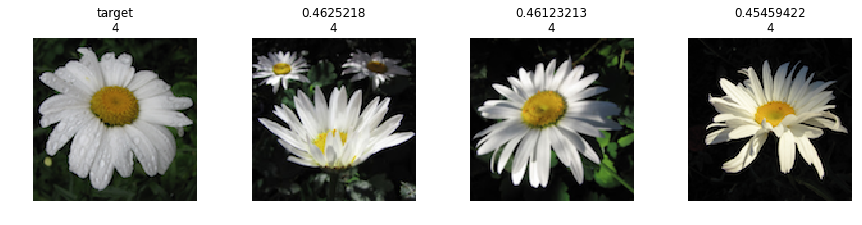

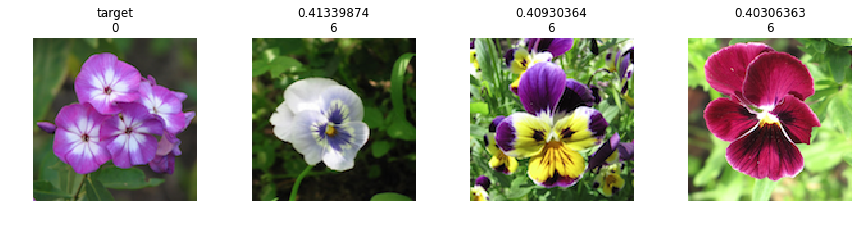

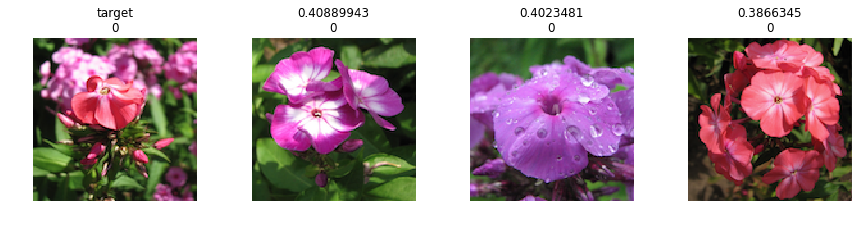

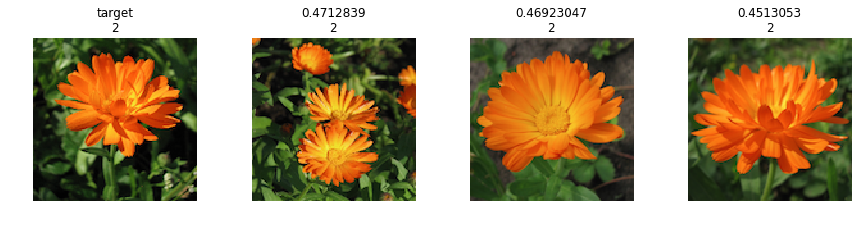

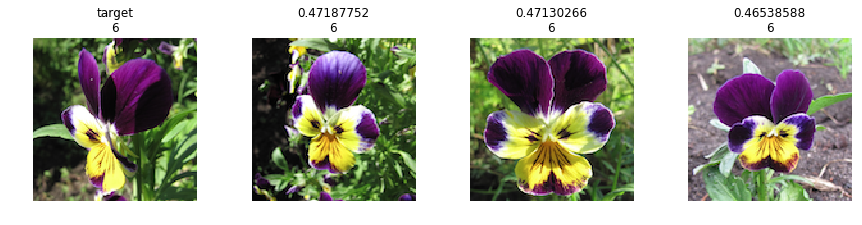

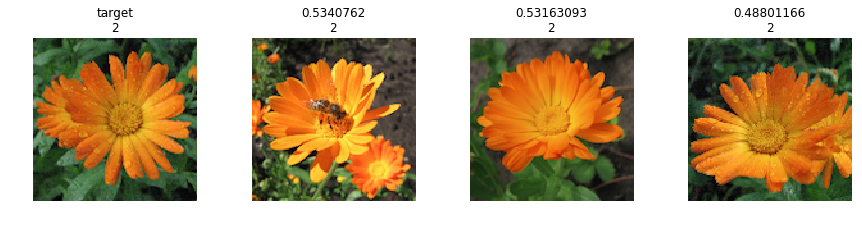

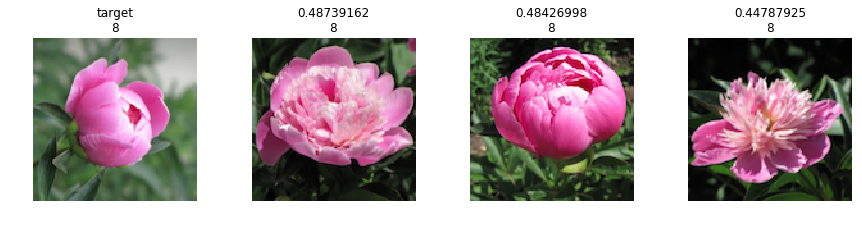

In [38]:
samples = np.random.randint(0, len(paths), 10)

for i in samples:
    
    sim_idxs = np.argsort(cos_sims[i])[::-1]
    sim_idxs = np.delete(sim_idxs, np.where(sim_idxs==i))
    
    sim_num = 3
    sim_idxs = sim_idxs[:sim_num]
    fig, axs = plt.subplots(ncols=sim_num+1, figsize=(15, sim_num))
    img = Image.open(paths[i])
    axs[0].imshow(img)
    axs[0].set_title('target\n'+str(labels[i]))
    axs[0].axis('off')
    
    for j in range(sim_num):
        img = Image.open(paths[sim_idxs[j]])
        axs[j+1].imshow(img)
        axs[j+1].set_title(str(cos_sims[i, sim_idxs[j]])+'\n'+str(labels[sim_idxs[j]]))
        axs[j+1].axis('off')
        
    plt.show()

In [39]:
!python --version

Python 3.6.3


In [40]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
certifi==2018.4.16
chainer==4.0.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
kaggle==1.4.5
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0.2.0
pexpect==4.5.0
pickleshare==0.7.4
Pillow==5.1.0
prompt-toolkit==1.0.15
protobuf==3.5.2.post1
ptyprocess==0.5.2
pycurl==7.43.0
Pygments==

In [42]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [43]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
